# Finding meaning in the noise: clusters, demographics, and year over year price change in real estate #

### Final Project for W207 Fall 2020 ###

Authors: Emily Brantner, Duncan Howard, Joshua Noble, Gabriel Ohaike, Sarah Yifei Wang
Instructor: Peter Grabowski

## Intro ##

This notebook uses the HDBSCAN library for clustering, which can be installed using the instructions found [here](https://pypi.org/project/hdbscan/)

It makes use of data acquired from: 

Social Explorer: www.socialexplorer.com from the following report: http://www.socialexplorer.com/pub/reportdata/HtmlResults.aspx?reportid=R12683096

Redfin, a national real estate brokerage: https://www.redfin.com/news/data-center/

In [1]:
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

First we'll load our dataframe and delete some columns which are part of the ACS template, but are all empty:

In [2]:
#load dataframe from csv
demographics_data = pd.read_csv("2018_demographic_data_edited.csv", delimiter=',')
print(demographics_data.shape)
demographics_data = demographics_data.drop(columns=["Geo_ZCTA5", "Geo_ZCTA3", "Geo_LOGRECNO", "Geo_GEOCOMP", "Geo_SUMLEV"])

(33120, 2151)


The fields are codes from the ACS survey for which the key can be found [here](2018_demographic_key.txt). The fields are in some places numerical data and in others categorical, averages in some cases, and aggregates in others.

As we can see here, the data is a bit spotty in places:

In [3]:
null_counts = demographics_data.isnull().sum()
print(null_counts[null_counts > 0])

SE_A01004_001      564
SE_A01004_002      843
SE_A01004_003      897
SE_A10003_001      726
SE_A10003B_001    2496
                  ... 
SE_A13007_009       35
SE_A13007_010       35
SE_A13007_011       35
SE_A10064_001       35
SE_A10064_002       35
Length: 870, dtype: int64


870 of our 2151 fields have null results, so we can drop any column with missing values greater than 7.5%

In [4]:
drop_columns = []

for i in demographics_data.columns:
    if demographics_data[i].isnull().sum()/len(demographics_data) > 0.075:
        drop_columns.append(i)
        
demographics_data = demographics_data.drop(columns=drop_columns)
print(demographics_data.shape)

(33120, 2038)


Now we've gotten rid of most of the fields that could cause us problems later. However, plenty of fields are still null for certain zip codes, so we'll be making heavy use of fillna throughout.

## Clustering ##

After some experimentation, we arrived at meaningful clusters using HDBSCAN and the following fields: Gini index of the zip code, Average household income of the zip code, vacancy rate of homes in the zip code, the ratio of average home value to average income in the zip code, and the ratio of residents who rent rather than own their residences:

In [5]:

# gini index, median household income, and area of occupation
reduced_demos = demographics_data[["zip", "SE_A14028_001", "SE_A14018_001", "SE_A17009_002", "SE_A17009_003", "SE_A17009_004", "SE_A17009_005", "SE_A17009_006"]]
reduced_demos.is_copy = False
# create 3 new metrics
reduced_demos = reduced_demos.assign(vacancy_rate=demographics_data["SE_A10001_001"].divide(demographics_data["SE_A10044_002"]))
reduced_demos = reduced_demos.assign(income_to_homevalue = demographics_data["SE_A10036_001"].divide(demographics_data["SE_A14018_001"]))
reduced_demos = reduced_demos.assign(renters_pct= demographics_data["SE_A10060_003"].divide(demographics_data["SE_A10001_001"]))

# how many null counts do we have?
null_counts = reduced_demos.isnull().sum()
print(null_counts[null_counts > 0])
reduced_demos = reduced_demos.dropna()
print(reduced_demos.shape)

reduced_demos_no_zip = reduced_demos.drop("zip", axis=1).copy()

SE_A14028_001           948
SE_A14018_001          1220
SE_A17009_002            35
SE_A17009_003            35
SE_A17009_004            35
SE_A17009_005            35
SE_A17009_006            35
vacancy_rate            490
income_to_homevalue    2502
renters_pct             490
dtype: int64
(30618, 11)


/Users/duncanhoward/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5191: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/duncanhoward/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5192: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


Now that we have demographic data for our clustering, we can go ahead and cluster using HDBSCAN. We want to minimize the number of points classified as noise and also look for clusters which are similar in size. Having extremely small or extremely large clusters likely will be a sign that we haven't selected appropriate statistics or that we need to tune parameters for clustering:

Created  106  clusters and  2308  noise points. Noise is  0.075  of dataset 


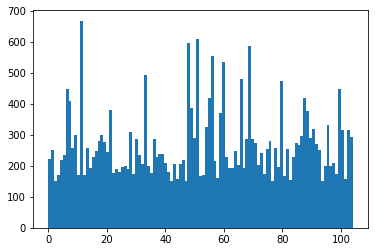

In [6]:

# run the clustering algorithm, use leaf to ensure that we keep creating clusters from large clusters 
clusterer = hdbscan.HDBSCAN(min_cluster_size=150, min_samples=3, cluster_selection_method='leaf')
clusterer.fit(reduced_demos_no_zip)

# how many labels do we have and how much noise has HDBSCAN discarded?
labels = clusterer.labels_
unique_labels = set(labels)
print( "Created ", len(unique_labels), " clusters and ", (labels == -1).sum(), " noise points. Noise is ", round((labels == -1).sum()/len(labels), 3), " of dataset ")

#how many zip codes are in each cluster?
label_sum = []

for k in unique_labels:
    label_sum.append((labels == k).sum())
    
non_noise = labels[labels != -1]

# graph all the non-noise labels so that we can see what we have
plt.hist(non_noise, bins=len(unique_labels)-1)
plt.show()

There are several large clusters (>500) but largely our clusterng seems homogenous in size. Only 7.5% of our zip codes are noise, meaning that 92.5% of our zip codes are within clusters. Now we can begin to turn our clusters into data that we can use in a linear regrssion. There's some data massaging we need to do in order to prepare for the regression though. First, we'll use a dataframe to store just the zip code for each cluster.

In [7]:
clusters = reduced_demos[['zip']]
clusters = clusters.assign(cluster=labels)
clusters.head()

,zip,cluster
0,601,56
1,602,30
2,603,15
3,606,77
4,610,41


Now let's get the sales data for each zip code:

In [8]:
#changing this to be a more descriptive name, adding file to git as well
sales_data = pd.read_csv("sarah_yoy.csv", header = 1)
sales_data.index = sales_data.index.astype(int)
sales_data = sales_data.rename(columns={"Region":"zip"})
#sales_data.set_index('zip', inplace = True)
sales_data = sales_data.fillna(0)
print(sales_data.head())

      zip  01/02/2016  01/03/2016  01/04/2016  01/05/2016  01/06/2016  \
0   501.0        0.00        0.00        0.00        0.00        0.00   
1  1005.0        0.15        0.06       -0.30       -0.24        0.34   
2  1010.0        0.00        0.00        0.00        0.00        0.00   
3  1031.0        7.05        6.12       -0.25       -0.25       -0.83   
4  1037.0        0.00        0.00       -0.24        0.00        1.03   

   01/07/2016  01/08/2016  01/09/2016  01/10/2016  ...  01/12/2019  \
0        0.00        0.00        0.00        0.00  ...        0.00   
1        0.09        0.06       -0.09       -0.04  ...        0.07   
2        0.00        0.00        0.00        0.00  ...        0.00   
3       -0.14       -0.03       -0.02        0.28  ...        0.44   
4        1.50        1.50        0.00        0.00  ...        0.00   

   01/01/2020  01/02/2020  01/03/2020  01/04/2020  01/05/2020  01/06/2020  \
0        0.00        0.00        0.00        0.00        0.00  

Now we get add the cluster labels to our sales data

In [9]:
cluster_sales = sales_data.merge(clusters, on="zip")
cluster_sales = cluster_sales.fillna(0)
cluster_sales.head()

,zip,01/02/2016,01/03/2016,01/04/2016,01/05/2016,01/06/2016,01/07/2016,01/08/2016,01/09/2016,01/10/2016,...,01/01/2020,01/02/2020,01/03/2020,01/04/2020,01/05/2020,01/06/2020,01/07/2020,01/08/2020,01/09/2020,cluster
0,1005.0,0.15,0.06,-0.30,-0.24,0.34,0.09,0.06,-0.09,-0.04,...,-0.04,0.06,-0.08,0.02,-0.04,0.12,-0.01,0.05,0.01,33
1,1010.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,38
2,1031.0,7.05,6.12,-0.25,-0.25,-0.83,-0.14,-0.03,-0.02,0.28,...,-0.14,0.71,1.62,1.27,-0.01,-0.38,-0.48,-0.51,6.81,79
3,1037.0,0.00,0.00,-0.24,0.00,1.03,1.50,1.50,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.24,-0.15,80
4,1057.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,35


Now create a dataframe which contains the mean sales data across all months for each zipcode in the cluster

In [10]:
cluster_names = []
mean_yoy_by_cluster = pd.DataFrame()

for c in np.unique(cluster_sales["cluster"]):
    sub = cluster_sales[(cluster_sales['cluster'] == c)]
    sub_no_zip = sub.drop(columns=["cluster", "zip"])
    tmp_df = sub_no_zip.mean(1).to_frame()
    #tmp_df = tmp_df.transpose()
    tmp_df["cluster"] = c
    tmp_df["zip"] = sub["zip"]
    tmp_df.set_index("zip")
    mean_yoy_by_cluster = mean_yoy_by_cluster.append(tmp_df, ignore_index=True)

print(mean_yoy_by_cluster[mean_yoy_by_cluster["cluster"] == 1].head())
mean_yoy_by_cluster[mean_yoy_by_cluster["cluster"] == 1].shape

             0  cluster     zip
1517  0.045714        1  1545.0
1518  0.060536        1  1701.0
1519  0.071071        1  1801.0
1520  0.076071        1  1844.0
1521  0.057679        1  1890.0


(240, 3)

Now we need to get the demographic data of selected fields for each cluster

In [11]:

all_cluster_demos = pd.DataFrame()

# we'll just start with 1 to see if it works, can become all later

for c in np.unique(clusters["cluster"]):
    zip_codes_for_cluster = mean_yoy_by_cluster[mean_yoy_by_cluster["cluster"] == c]
    cluster_demographics = demographics_data[demographics_data['zip'].isin(zip_codes_for_cluster["zip"])]
    cluster_demographics = cluster_demographics[['zip', 'SE_B01001_003','SE_B01001_004', 'SE_A14001_014', 'SE_A14001_015', 'SE_A14001_016', 'SE_A14001_017', 'SE_A00002_002']]
    cluster_demographics.rename(columns = {"SE_B01001_003": "Population_18-34","SE_B01001_004": "Population_35-64","SE_A14001_014":"Income_100-124k","SE_A14001_015":"Income_125-149k","SE_A14001_016":"Income_150-199k","SE_A14001_017":"Income>200k", "SE_A00002_002":"Population_Density"}, inplace = True)
    cluster_demographics["cluster"] = c
    all_cluster_demos = all_cluster_demos.append(cluster_demographics, ignore_index=True)

all_cluster_demos = all_cluster_demos.set_index('zip')
print(all_cluster_demos.head())
all_cluster_demos[all_cluster_demos["cluster"] == 1].shape

      Population_18-34  Population_35-64  Income_100-124k  Income_125-149k  \
zip                                                                          
1453              9084             16778           1489.0           1107.0   
1503               451              1395            153.0             91.0   
1590              1397              4295            450.0            281.0   
1607              2301              3641            281.0            166.0   
1702             11370             15189           1404.0            738.0   

      Income_150-199k  Income>200k  Population_Density  cluster  
zip                                                              
1453           1023.0        710.0           1460.0410       -1  
1503            162.0        170.0            242.3325       -1  
1590            463.0        627.0            293.1133       -1  
1607            102.0         74.0           2713.8210       -1  
1702           1030.0        744.0           4839.5380   

(240, 8)

In [12]:
# now use zip as the index for the demographics
mean_yoy_by_cluster_ind = mean_yoy_by_cluster.set_index("zip")

In [13]:
all_cluster_demos[all_cluster_demos["cluster"] == 1]

,Population_18-34,Population_35-64,Income_100-124k,Income_125-149k,Income_150-199k,Income>200k,Population_Density,cluster
zip,,,,,,,,
1545,6406,15544,1413.0,1374.0,1537.0,2531.0,1767.3880,1
1701,5670,14638,1577.0,1445.0,1854.0,2333.0,1919.5890,1
1801,9319,16556,2270.0,1466.0,1702.0,1479.0,3186.4410,1
1844,11016,20772,2121.0,1248.0,1866.0,1467.0,2251.8700,1
1890,2761,9627,597.0,663.0,914.0,3255.0,3759.1830,1
...,...,...,...,...,...,...,...,...
98125,11863,16521,1746.0,1039.0,1578.0,1694.0,7871.8840,1
98133,12284,19725,1915.0,1330.0,1643.0,1357.0,6659.4610,1
98682,14390,22042,2183.0,1517.0,1230.0,809.0,1928.8460,1


Next, we will represent our clustering visually using the explanatory variables we will use in the regression section. The first plot is colored by cluster number.

/Users/duncanhoward/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

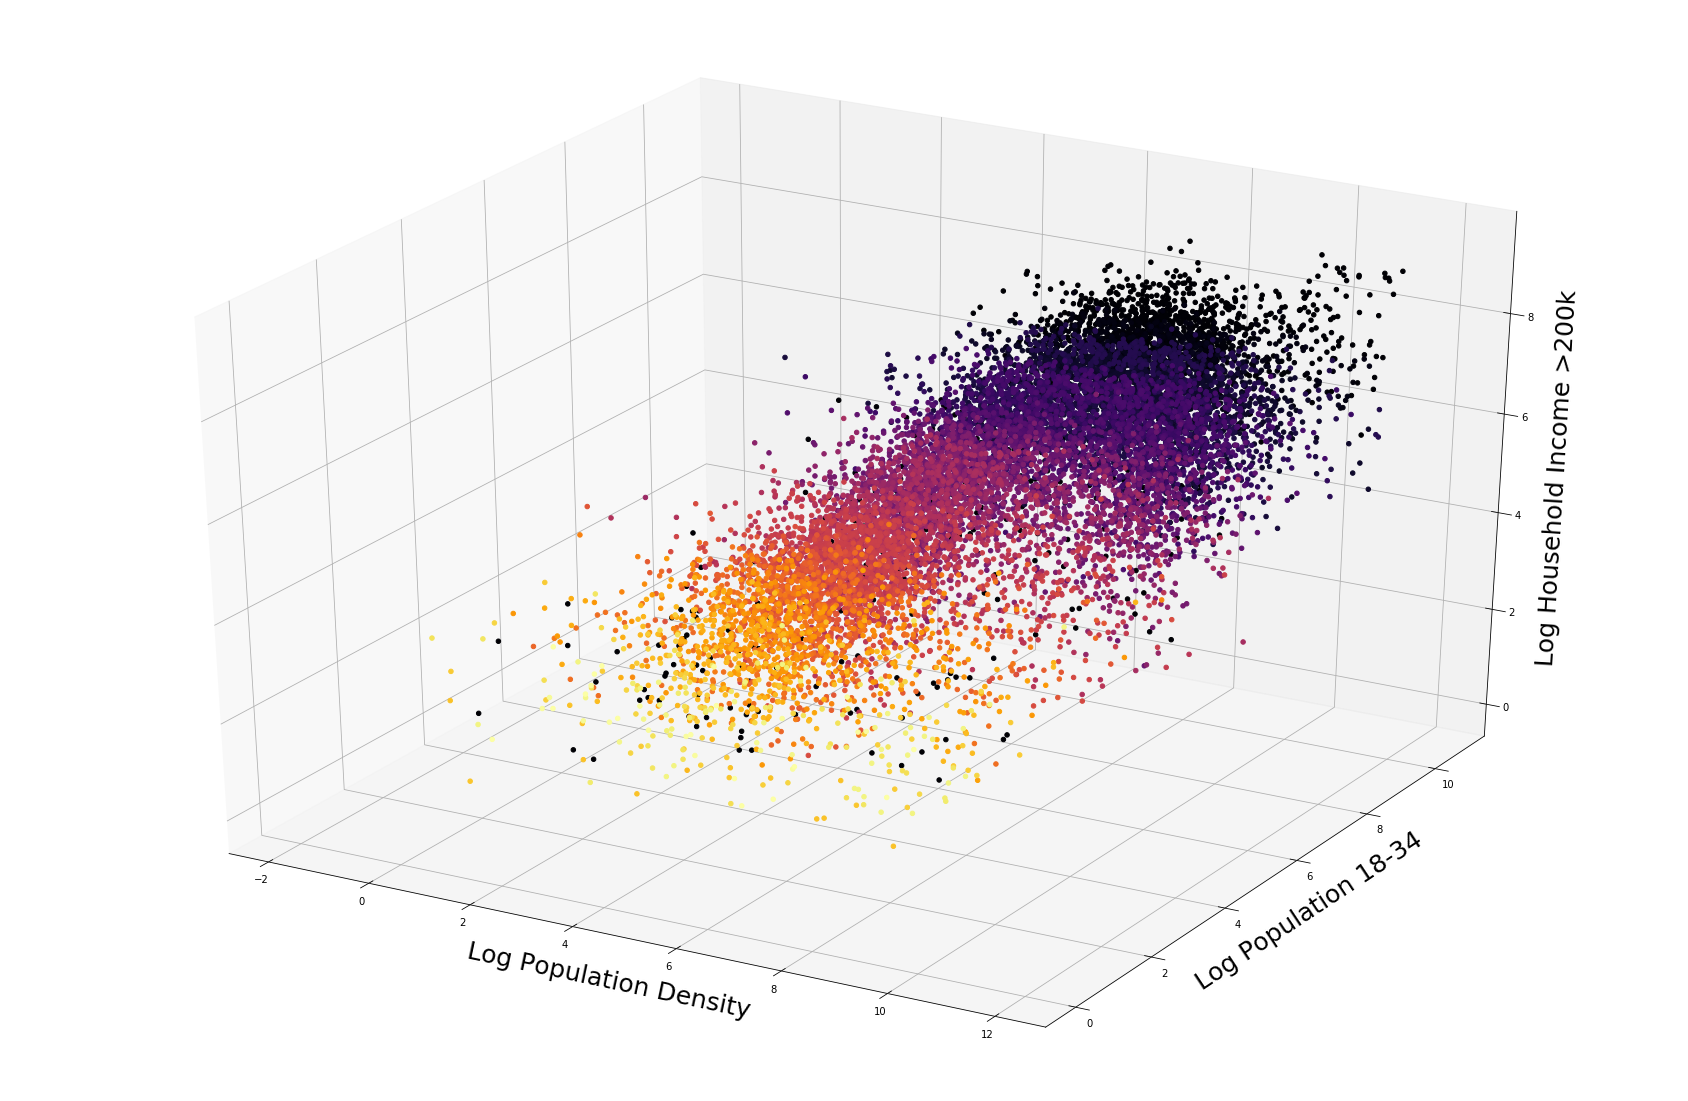

In [14]:
fig = plt.figure()
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111, projection='3d')

x = np.log(all_cluster_demos["Population_Density"])
y = np.log(all_cluster_demos["Population_18-34"])
z = np.log(all_cluster_demos["Income>200k"])
c = all_cluster_demos["cluster"]

ax.scatter(xs=x, ys=y, zs=z, c=c, cmap = 'inferno', alpha=1)

ax.set_xlabel('\nLog Population Density', fontsize=25)
ax.set_ylabel('\nLog Population 18-34', fontsize=25)
ax.set_zlabel('\nLog Household Income >200k', fontsize=25)

plt.show()

We can see that the clustering algorithm found a meaningful grouping for our regression data, even though it didn't go into the clustering algorithm. Now how does our YoY data look on the same plot?

<Figure size 432x288 with 0 Axes>

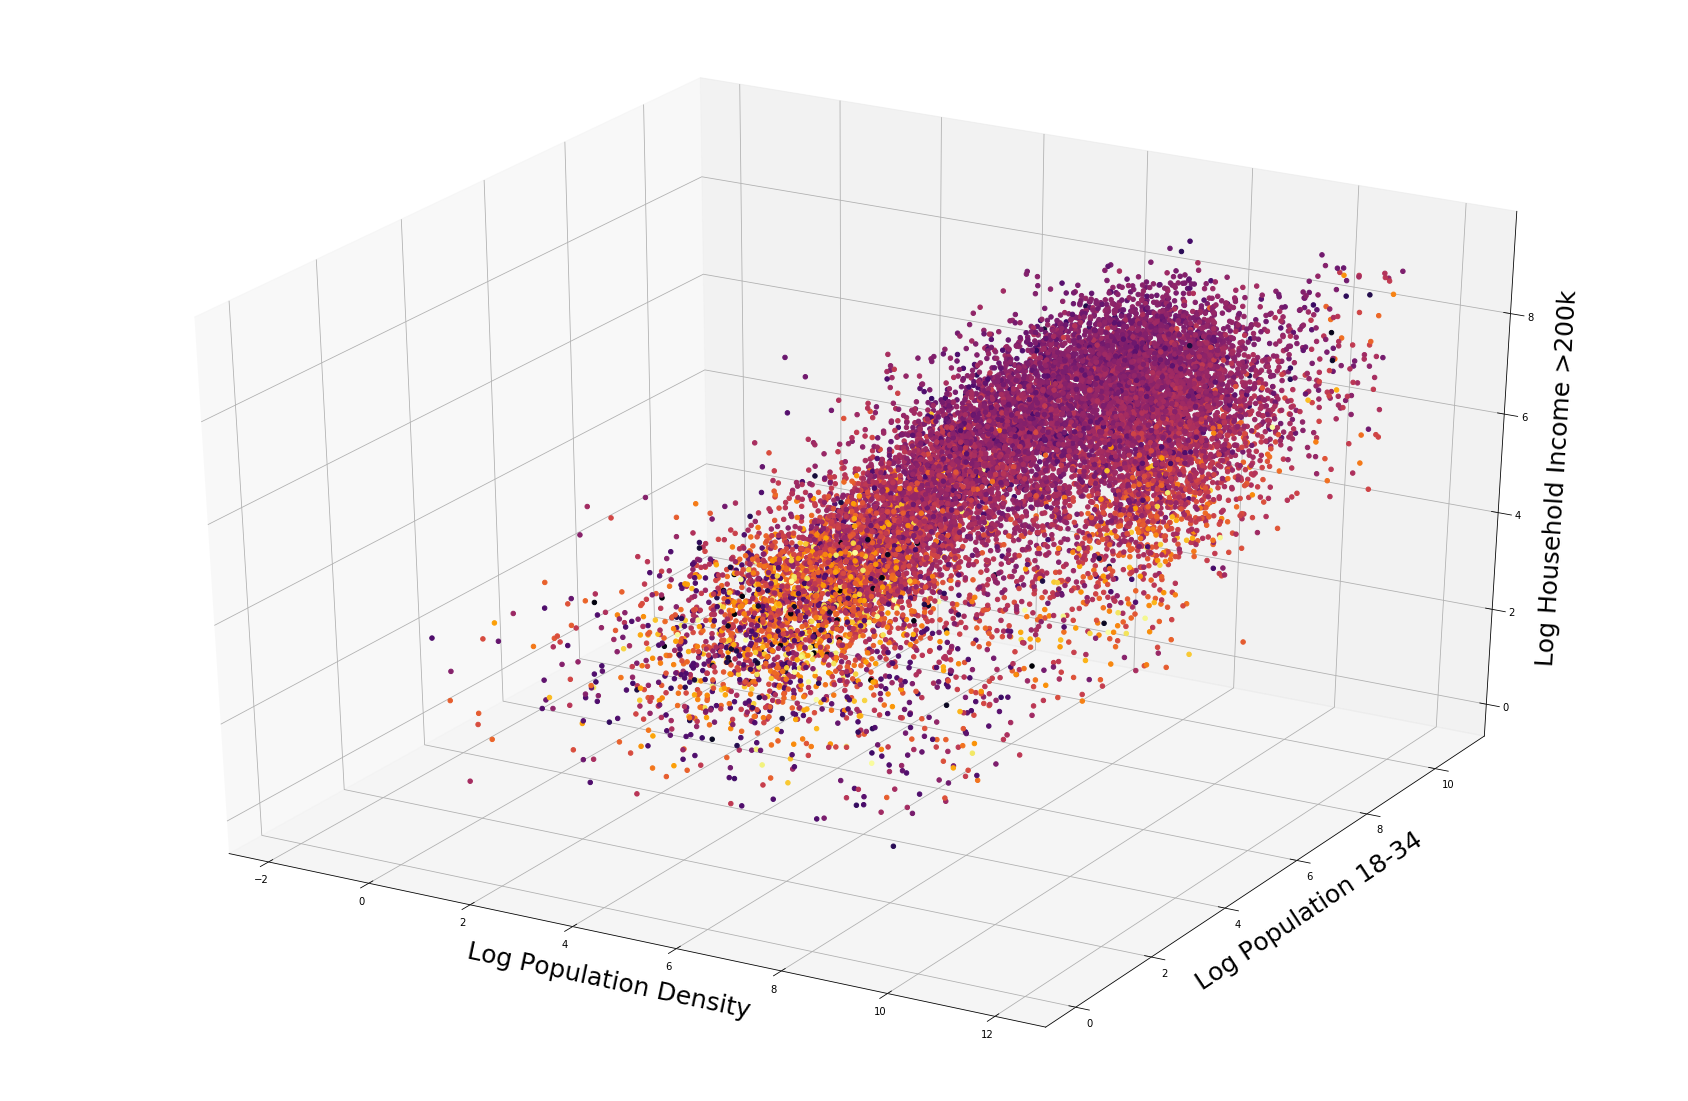

In [15]:
fig = plt.figure()
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111, projection='3d')

x = np.log(all_cluster_demos["Population_Density"])
y = np.log(all_cluster_demos["Population_18-34"])
z = np.log(all_cluster_demos["Income>200k"])
c = (np.log(mean_yoy_by_cluster[0]+0.1)%3)

ax.scatter(xs=x, ys=y, zs=z, c=c, cmap = 'inferno', alpha=1)

ax.set_xlabel('\nLog Population Density', fontsize=25)
ax.set_ylabel('\nLog Population 18-34', fontsize=25)
ax.set_zlabel('\nLog Household Income >200k', fontsize=25)

plt.show()

The plot above is colored by the YoY sales value distributuion. Our regressions below will examine whether we are able to more accurately model this value within each cluster or within the overall dataset. At first glance, the sales data, our dependent variable, is not nearly as clean as clusters themselves, but within each cluster there are likly to be trends. 


## Regression ##

Now we can regress sales data against selected demographic features in each cluster.

In [16]:

all_models = []

for c in np.unique(clusters["cluster"]):
    X = all_cluster_demos[all_cluster_demos["cluster"] == c][['Population_18-34','Population_35-64', 'Income_100-124k', 'Income_125-149k', 'Income_150-199k', 'Income>200k','Population_Density']]
    Y = mean_yoy_by_cluster_ind[mean_yoy_by_cluster_ind["cluster"] == c][0]
    model = sm.OLS(Y, X).fit()
    all_models.append({"cluster":c, "model":model})
    


Because we have a large number of clusters and selected demographic features have different forecasting power to each cluster, we are more interested in which clusters' sales data can be better forecasted by selected demographic data

In [17]:
rsq_adj = []
rsq = []
fstat = []

for m in all_models:
    rsq_adj.append(m["model"].rsquared_adj)
    rsq.append(m["model"].rsquared)
    fstat.append(m["model"].fvalue)
    
print(" our best rsq adjusted across all of our models is", np.max(rsq_adj))
print(" our best rsq across all of our models is", np.max(rsq))
print(" our best f stat across all of our models is", np.max(fstat))
print(" our average rsq adjusted accross all of our models is", np.average(rsq_adj))
print(" our lowest rsq adjusted accross all of our models is", np.min(rsq_adj))

 our best rsq adjusted across all of our models is 0.8804280195367171
 our best rsq across all of our models is 0.8839155356335628
 our best f stat across all of our models is 398.082636816682
 our average rsq adjusted accross all of our models is 0.5721997680120534
 our lowest rsq adjusted accross all of our models is -0.022655779764283235


In [18]:
best_rsp = np.where(rsq==np.max(rsq))
best_rsp[0][0]

2

Our model's forecasting power varies in each cluster. Taking 2nd cluster as an example, the model is able to explan 88% of the variation in sales data. Our model is positively correlated to the population between 35-64, income between 100k and 124k, or income between 150k and 199k, because they have more purchasing power for houses.

In [19]:
all_models[best_rsp[0][0]]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.884
Model:                            OLS   Adj. R-squared (uncentered):              0.880
Method:                 Least Squares   F-statistic:                              253.5
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                   3.75e-105
Time:                        16:52:56   Log-Likelihood:                          569.89
No. Observations:                 240   AIC:                                     -1126.
Df Residuals:                     233   BIC:                                     -1101.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Population_18-34    1.634e-07    4.8e-07      0.340      0.734   -7.82e-07    1.11e-06
Population_35-64    1.128e-06   4.52e-07      2.495      0.013    2.38e-07    2.02e-06
Income_100-124k     1.477e-05   5.29e-06      2.792      0.006    4.35e-06    2.52e-05
Income_125-149k      1.11e-05   7.81e-06      1.421      0.157   -4.29e-06    2.65e-05
Income_150-199k    -1.143e-05      6e-06     -1.906      0.058   -2.33e-05    3.82e-07
Income>200k         8.184e-06   2.08e-06      3.940      0.000    4.09e-06    1.23e-05
Population_Density  5.329e-07   1.86e-07      2.869      0.005    1.67e-07    8.99e-07
==============================================================================
Omnibus:                       20.637   Durbin-Watson:                   1.613
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.019
Skew:                           0.272   Prob(JB):                     9.27e-14
Kurtosis:                       5.389   Cond. No.                         140.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

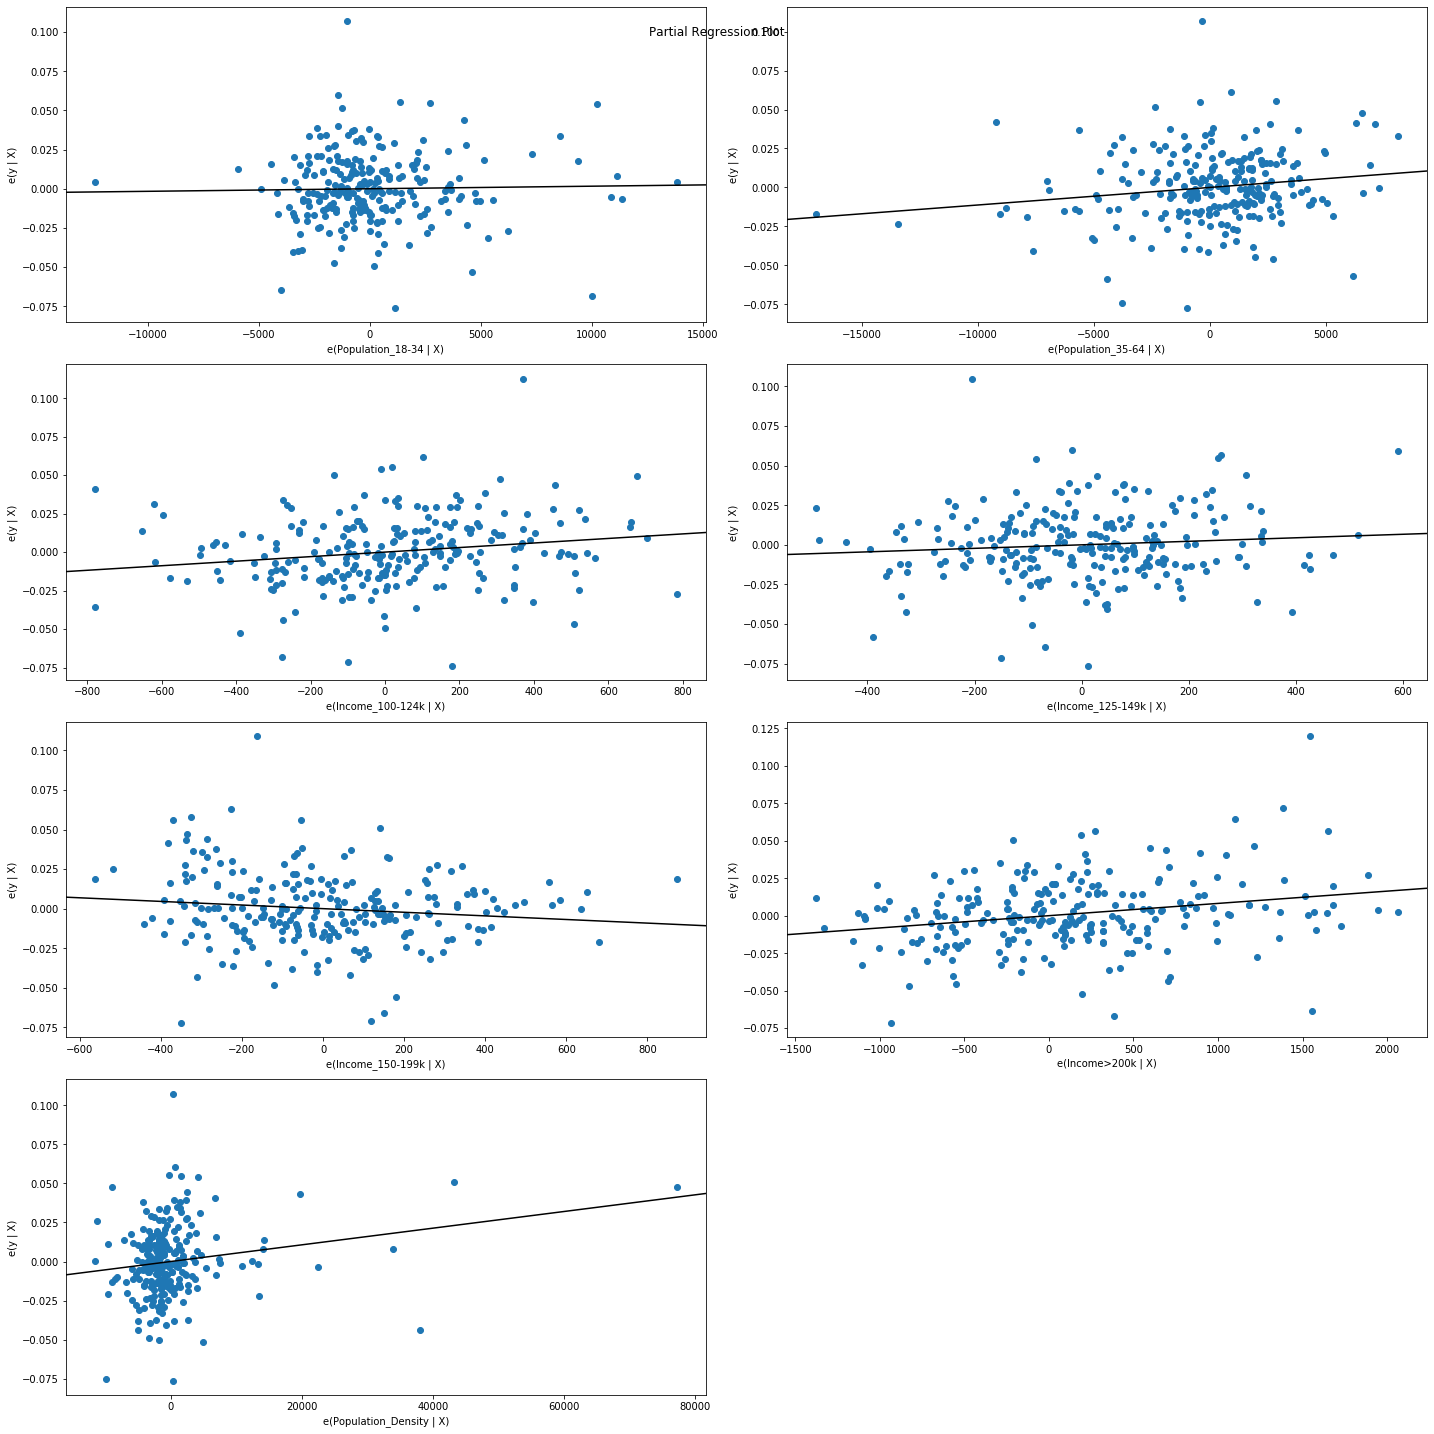

In [20]:
plt.rc("figure", figsize=(20,20))
figure = sm.graphics.plot_partregress_grid(all_models[best_rsp[0][0]]['model'])
figure.tight_layout(pad=1.0)

## Compare to non-clustered

In [21]:
    X = all_cluster_demos[['Population_18-34','Population_35-64', 'Income_100-124k', 'Income_125-149k', 'Income_150-199k', 'Income>200k','Population_Density']]
    Y = mean_yoy_by_cluster_ind[0]
    model2 = sm.OLS(Y, X).fit()
    model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.2911
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                       0.958
Time:                        16:52:57   Log-Likelihood:                         -45719.
No. Observations:               14659   AIC:                                  9.145e+04
Df Residuals:                   14652   BIC:                                  9.150e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Population_18-34   -2.809e-06   2.31e-05     -0.122      0.903   -4.81e-05    4.25e-05
Population_35-64    1.216e-05   2.19e-05      0.556      0.578   -3.07e-05    5.51e-05
Income_100-124k     1.001e-05      0.000      0.034      0.973      -0.001       0.001
Income_125-149k     -3.99e-05      0.000     -0.090      0.928      -0.001       0.001
Income_150-199k    -4.023e-05      0.000     -0.121      0.904      -0.001       0.001
Income>200k        -3.715e-06      0.000     -0.033      0.974      -0.000       0.000
Population_Density  1.199e-06   7.63e-06      0.157      0.875   -1.38e-05    1.62e-05
==============================================================================
Omnibus:                    61829.185   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     130689188083.901
Skew:                         120.886   Prob(JB):                         0.00
Kurtosis:                   14628.609   Cond. No.                         136.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

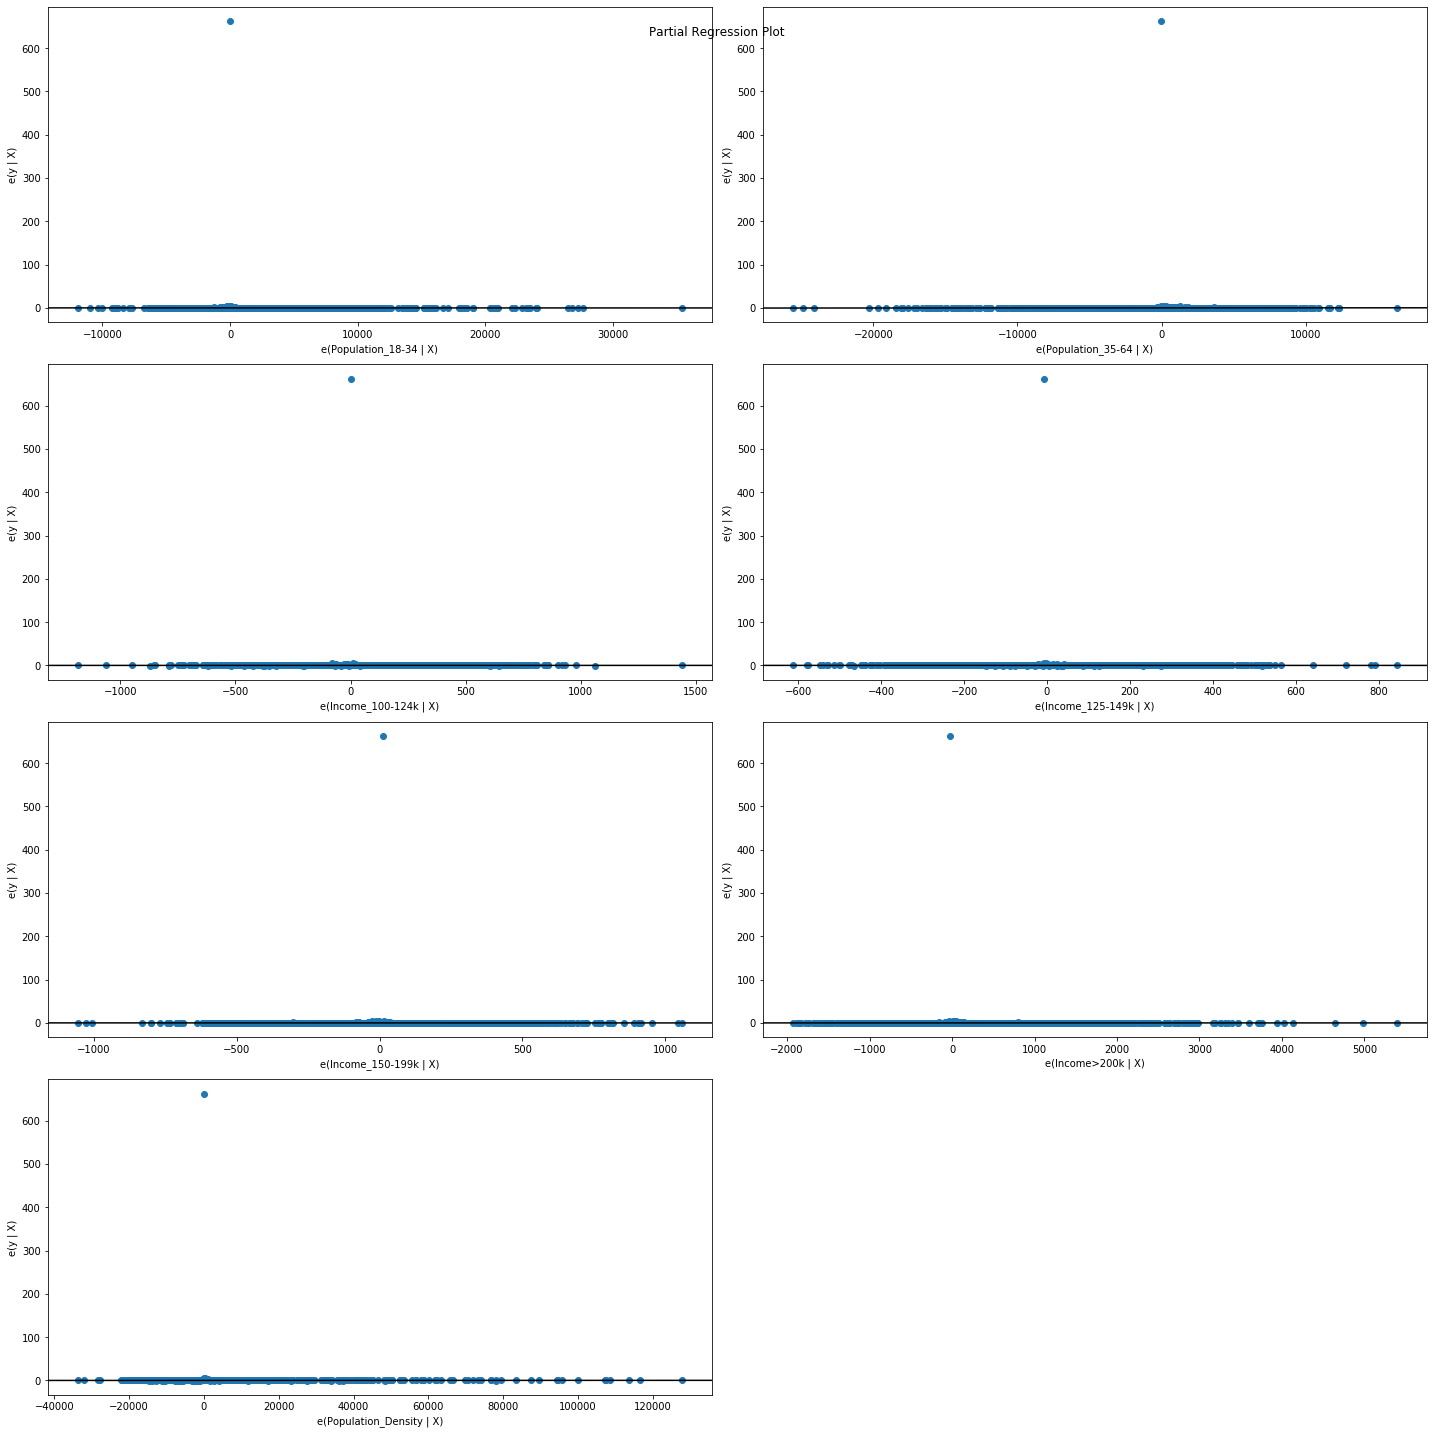

In [22]:
plt.rc("figure", figsize=(20,20))
figure = sm.graphics.plot_partregress_grid(model2)
figure.tight_layout(pad=1.0)

## Playing with clusters

In [23]:
emilys_zip = mean_yoy_by_cluster[mean_yoy_by_cluster["zip"] == 17101]
print(emilys_zip)

duncans_zip = mean_yoy_by_cluster[mean_yoy_by_cluster["zip"] == 2110]
print(duncans_zip)

joshs_zip = mean_yoy_by_cluster[mean_yoy_by_cluster["zip"] == 98826]
print(joshs_zip)

              0  cluster      zip
11759  0.062857       60  17101.0
             0  cluster     zip
7249  0.105179       28  2110.0
             0  cluster      zip
8359  0.190536       34  98826.0
